In [1]:
## load the libraries 
from keras.layers import Dense, Input, Conv2D, LSTM, MaxPool2D, UpSampling2D
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical
from numpy import argmax, array_equal
import matplotlib.pyplot as plt
from keras.models import Model
from imgaug import augmenters
from random import randint
import pandas as pd
import numpy as np

Using TensorFlow backend.


### 2. Dataset Prepration 

Load the dataset, separate predictors and target, normalize the inputs.

In [2]:
### read dataset 
train = pd.read_csv("../input/fashion-mnist_train.csv")
train_x = train[list(train.columns)[1:]].values
train_y = train['label'].values

## normalize and reshape the predictors  
train_x = train_x / 255

## create train and validation datasets
train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size=0.2)

## reshape the inputs
train_x = train_x.reshape(-1, 784)
val_x = val_x.reshape(-1, 784)

### 3. Create Autoencoder architecture

In this section, lets create an autoencoder architecture. The encoding part comprises of three layers with 2000, 1200, and 500 nodes. Encoding architecture is connected to latent view space comprising of 10 nodes which is then connected to decoding architecture with 500, 1200, and 2000 nodes. The final layer comprises of exact number of nodes as the input layer.

In [3]:
## input layer
input_layer = Input(shape=(784,))

## encoding architecture
encode_layer1 = Dense(1500, activation='relu')(input_layer)
encode_layer2 = Dense(1000, activation='relu')(encode_layer1)
encode_layer3 = Dense(500, activation='relu')(encode_layer2)

## latent view
latent_view   = Dense(10, activation='sigmoid')(encode_layer3)

## decoding architecture
decode_layer1 = Dense(500, activation='relu')(latent_view)
decode_layer2 = Dense(1000, activation='relu')(decode_layer1)
decode_layer3 = Dense(1500, activation='relu')(decode_layer2)

## output layer
output_layer  = Dense(784)(decode_layer3)

model = Model(input_layer, output_layer)

Here is the summary of our autoencoder architecture.

In [4]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1500)              1177500   
_________________________________________________________________
dense_2 (Dense)              (None, 1000)              1501000   
_________________________________________________________________
dense_3 (Dense)              (None, 500)               500500    
_________________________________________________________________
dense_4 (Dense)              (None, 10)                5010      
_________________________________________________________________
dense_5 (Dense)              (None, 500)               5500      
_________________________________________________________________
dense_6 (Dense)              (None, 1000)              501000    
__________

Next, we will train the model with early stopping callback.

In [5]:
model.compile(optimizer='adam', loss='mse')
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10)
model.fit(train_x, train_x, epochs=20, batch_size=2048, validation_data=(val_x, val_x), callbacks=[early_stopping])

Train on 48000 samples, validate on 12000 samples
Epoch 1/20
48000/48000 [==============================] - 5s 112us/step - loss: 0.0975 - val_loss: 0.0719
Epoch 2/20
48000/48000 [==============================] - 1s 20us/step - loss: 0.0652 - val_loss: 0.0541
Epoch 3/20
48000/48000 [==============================] - 1s 20us/step - loss: 0.0472 - val_loss: 0.0415
Epoch 4/20
48000/48000 [==============================] - 1s 20us/step - loss: 0.0394 - val_loss: 0.0369
Epoch 5/20
48000/48000 [==============================] - 1s 20us/step - loss: 0.0363 - val_loss: 0.0340
Epoch 6/20
48000/48000 [==============================] - 1s 21us/step - loss: 0.0334 - val_loss: 0.0322
Epoch 7/20
48000/48000 [==============================] - 1s 20us/step - loss: 0.0307 - val_loss: 0.0298
Epoch 8/20
48000/48000 [==============================] - 1s 20us/step - loss: 0.0280 - val_loss: 0.0260
Epoch 9/20
48000/48000 [==============================] - 1s 20us/step - loss: 0.0256 - val_loss: 0.0252
Epoc

Generate the predictions on validation data. 

In [6]:
preds = model.predict(val_x)

Lets plot the original and predicted image

**Inputs: Actual Images**

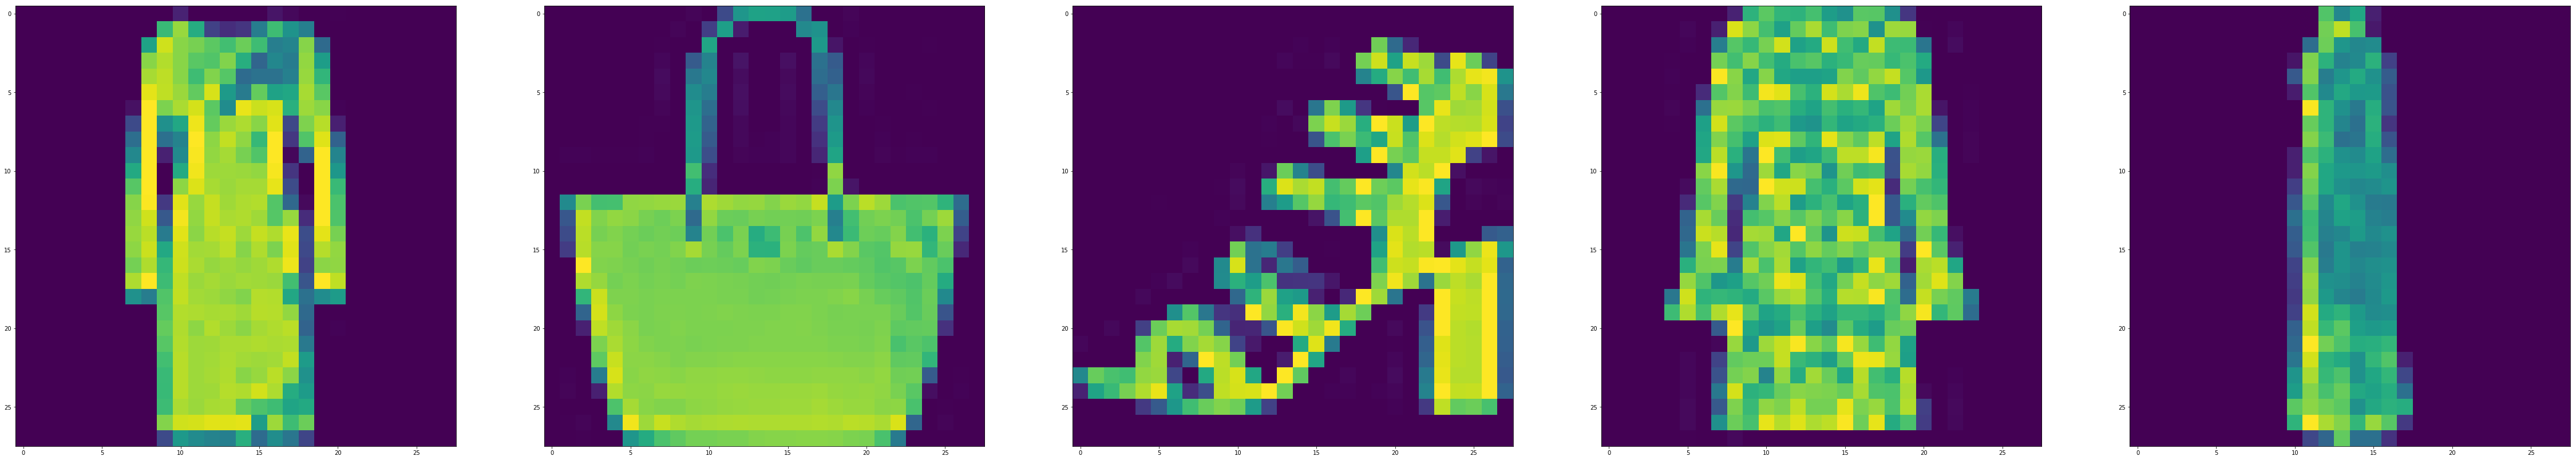

In [7]:
f, ax = plt.subplots(1,5)
f.set_size_inches(80, 40)
for i in range(5):
    ax[i].imshow(val_x[i].reshape(28, 28))
plt.show()

**Predicted : Autoencoder Output**

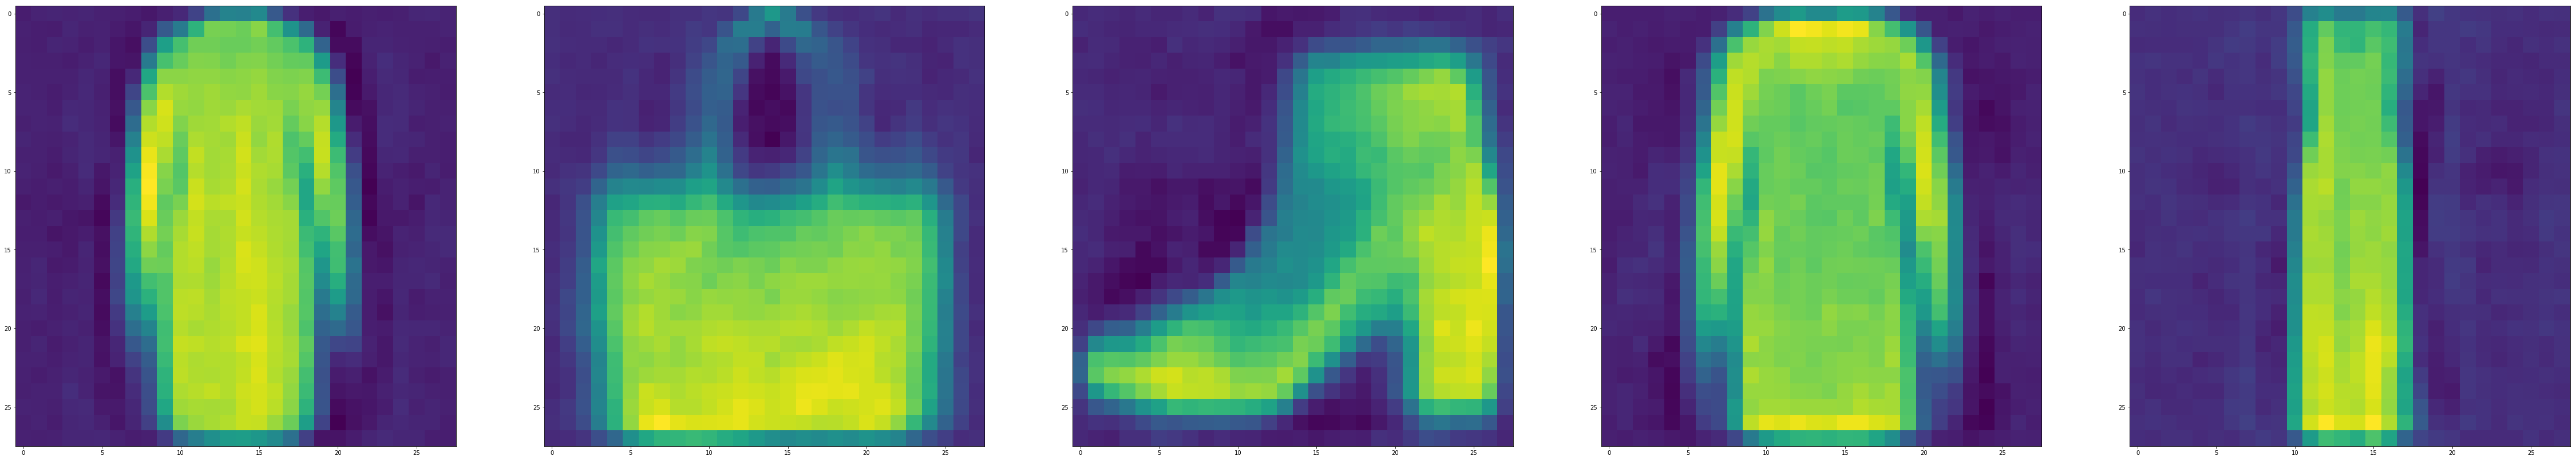

In [8]:
f, ax = plt.subplots(1,5)
f.set_size_inches(80, 40)
for i in range(5):
    ax[i].imshow(preds[i].reshape(28, 28))
plt.show()

In [19]:
rmse = np.sqrt(np.mean((val_x[0] - preds[0]) ** 2))
rmse

0.1412146949147585

So we can see that an autoencoder trained with 20 epoochs is able to reconstruct the input images very well. Lets look at other use-case of autoencoders - Image denoising or removal of noise from the image.  

## 2.2 UseCase 2 - Image Denoising

Autoencoders are pretty useful, lets look at another application of autoencoders - Image denoising. Many a times input images contain noise in the data, autoencoders can be used to get rid of those images. Lets see it in action. First lets prepare the train_x and val_x data contianing the image pixels. 

![](https://www.learnopencv.com/wp-content/uploads/2017/11/denoising-autoencoder-600x299.jpg)

In [9]:
## recreate the train_x array and val_x array
train_x = train[list(train.columns)[1:]].values
train_x, val_x = train_test_split(train_x, test_size=0.2)

## normalize and reshape
train_x = train_x/255.
val_x = val_x/255.

In this autoencoder network, we will add convolutional layers because convolutional networks works really well with the image inputs. To apply convolutions on image data, we will reshape our inputs in the form of 28 * 28 matrix. For more information related to CNN,  refer to my previous [kernel](https://www.kaggle.com/shivamb/a-very-comprehensive-tutorial-nn-cnn).  

In [10]:
train_x = train_x.reshape(-1, 28, 28, 1)
val_x = val_x.reshape(-1, 28, 28, 1)

### Noisy Images 

We can intentionally introduce the noise in an image. I am using imaug package which can be used to augment the images with different variations. One such variation can be introduction of noise. Different types of noises can be added to the images. For example: 

- Salt and Pepper Noise  
- Gaussian Noise  
- Periodic Noise  
- Speckle Noise  

Lets introduce salt and pepper noise to our data which is also known as impulse noise. This noise introduces sharp and sudden disturbances in the image signal. It presents itself as sparsely occurring white and black pixels. 

Thanks to @ColinMorris for suggesting the correction in salt and pepper noise.

In [11]:
# Lets add sample noise - Salt and Pepper
"""
 Salt and Pepper noise is a type of image noise where some pixels in the image are randomly set to either 
 the minimum or maximum intensity value (i.e., black or white). 
 This technique is often used to test the robustness of image processing algorithms.
"""
#This creates an augmenter that adds Salt and Pepper noise to the images.
#The argument 0.1 specifies the proportion of pixels to be affected by noise. 
#Here, 10% of the pixels in each image will be altered to either black (pepper) or white (salt).
noise = augmenters.SaltAndPepper(0.1)

seq_object = augmenters.Sequential([noise])
#train_x is scaled by division by 255 but salt pepper adds noise with values from 0 to 255 
# so we will multiply it first by 255 then to rescale it again we will divide it by 255
train_x_n = seq_object.augment_images(train_x * 255) / 255
val_x_n = seq_object.augment_images(val_x * 255) / 255

Before adding noise

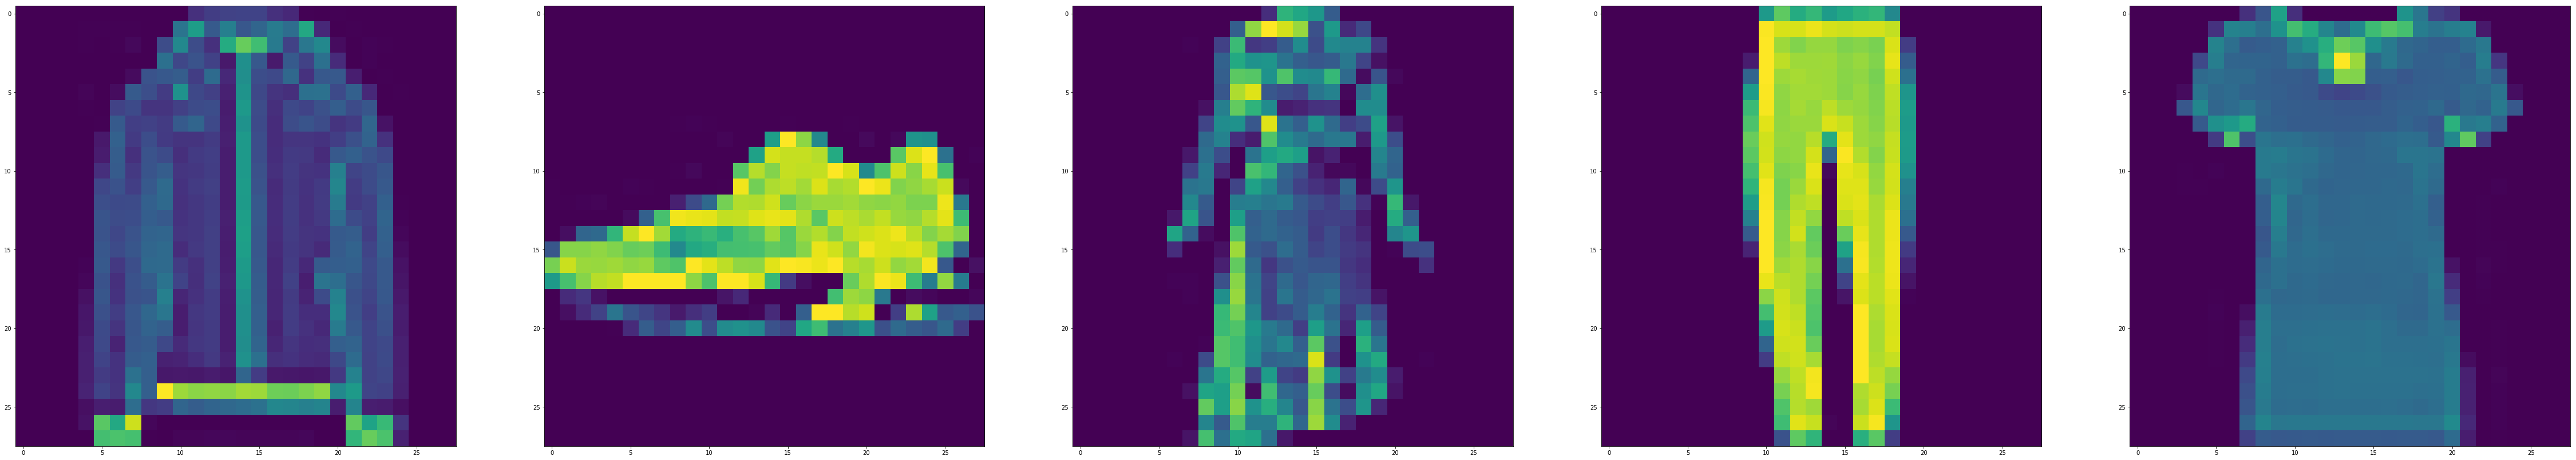

In [13]:
f, ax = plt.subplots(1,5)
f.set_size_inches(80, 40)
for i in range(5,10):
    ax[i-5].imshow(train_x[i].reshape(28, 28))
plt.show()

After adding noise

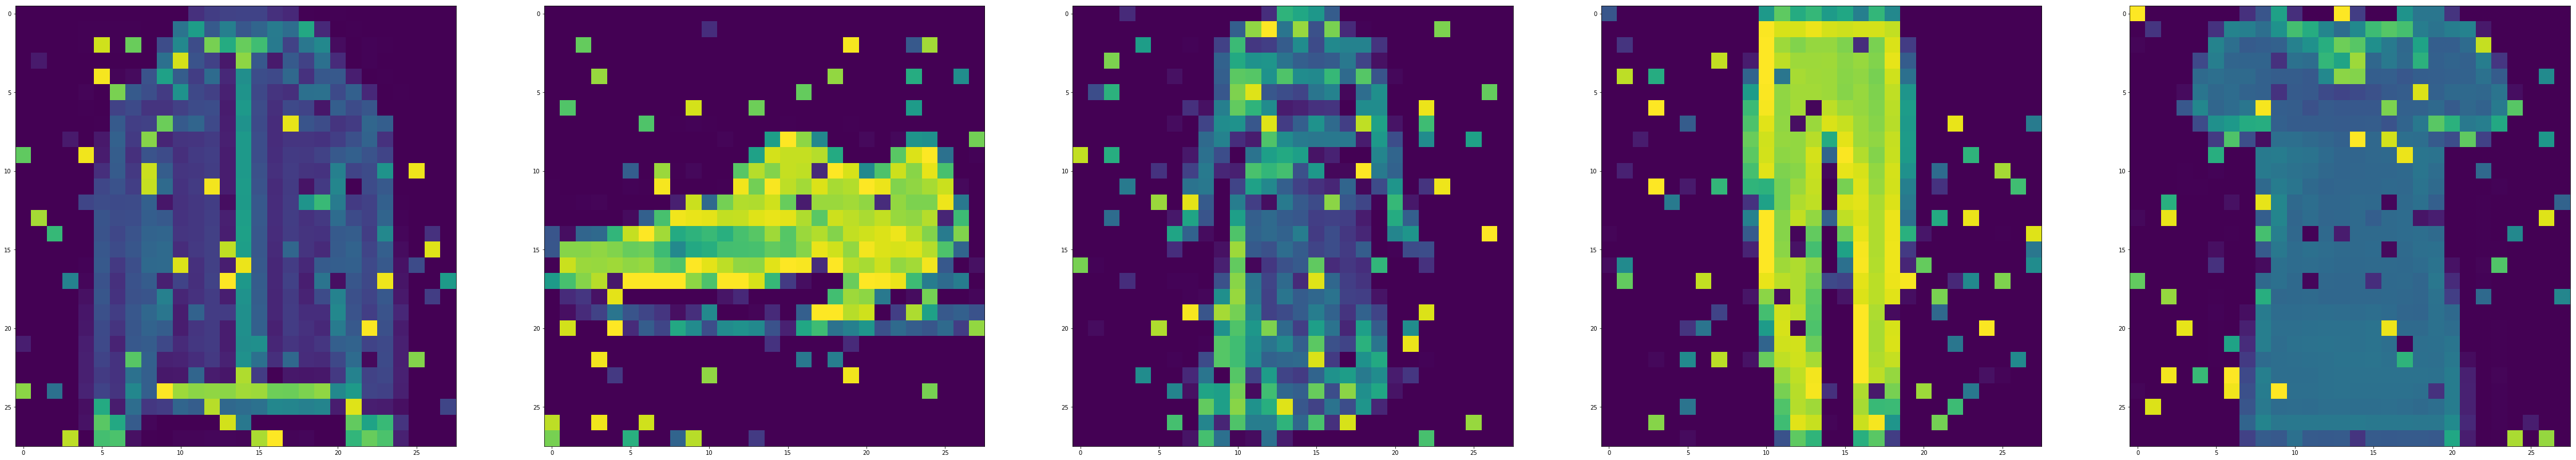

In [14]:
f, ax = plt.subplots(1,5)
f.set_size_inches(80, 40)
for i in range(5,10):
    ax[i-5].imshow(train_x_n[i].reshape(28, 28))
plt.show()

Lets now create the model architecture for the autoencoder. Lets understand what type of network needs to be created for this problem. 

**Encoding Architecture:**   

The encoding architure is composed of 3 Convolutional Layers and 3 Max Pooling Layers stacked one by one. Relu is used as the activation function in the convolution layers and padding is kept as "same". Role of max pooling layer is to downsample the image dimentions. This layer applies a max filter to non-overlapping subregions of the initial representation.  

**Decoding Architecture:**   

Similarly in decoding architecture, the convolution layers will be used having same dimentions (in reverse manner) as the encoding architecture. But instead of 3 maxpooling layers, we will be adding 3 upsampling layers. Again the activation function will be same (relu), and padding in convolution layers will be same as well.  Role of upsampling layer is to upsample the dimentions of a input vector to a higher resolution / dimention. The max pooling operation is non-invertible, however an approximate inverse can be obtained by recording the locations of the maxima within each pooling region. Umsampling layers make use of this property to project the reconstructions from a low dimentional feature space.   



In [15]:
# input layer
input_layer = Input(shape=(28, 28, 1))

# encoding architecture
encoded_layer1 = Conv2D(64, (3, 3), activation='relu', padding='same')(input_layer)
encoded_layer1 = MaxPool2D( (2, 2), padding='same')(encoded_layer1)
encoded_layer2 = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded_layer1)
encoded_layer2 = MaxPool2D( (2, 2), padding='same')(encoded_layer2)
encoded_layer3 = Conv2D(16, (3, 3), activation='relu', padding='same')(encoded_layer2)
latent_view    = MaxPool2D( (2, 2), padding='same')(encoded_layer3)

# decoding architecture
decoded_layer1 = Conv2D(16, (3, 3), activation='relu', padding='same')(latent_view)
decoded_layer1 = UpSampling2D((2, 2))(decoded_layer1)
decoded_layer2 = Conv2D(32, (3, 3), activation='relu', padding='same')(decoded_layer1)
decoded_layer2 = UpSampling2D((2, 2))(decoded_layer2)
decoded_layer3 = Conv2D(64, (3, 3), activation='relu')(decoded_layer2)
decoded_layer3 = UpSampling2D((2, 2))(decoded_layer3)
output_layer   = Conv2D(1, (3, 3), padding='same')(decoded_layer3)

# compile the model
model_2 = Model(input_layer, output_layer)
model_2.compile(optimizer='adam', loss='mse')

Here is the model summary

In [16]:
model_2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 64)        640       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 32)        18464     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 16)          4624      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 4, 4, 16)          0         
__________

Train the model with early stopping callback. Increase the number of epochs to a higher number for better results. 

In [17]:
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10)
history = model_2.fit(train_x_n, train_x, epochs=10, batch_size=2048, validation_data=(val_x_n, val_x), callbacks=[early_stopping])

Train on 48000 samples, validate on 12000 samples
Epoch 1/10
48000/48000 [==============================] - 6s 116us/step - loss: 0.0941 - val_loss: 0.0530
Epoch 2/10
48000/48000 [==============================] - 2s 45us/step - loss: 0.0442 - val_loss: 0.0372
Epoch 3/10
48000/48000 [==============================] - 2s 45us/step - loss: 0.0334 - val_loss: 0.0303
Epoch 4/10
48000/48000 [==============================] - 2s 45us/step - loss: 0.0285 - val_loss: 0.0268
Epoch 5/10
48000/48000 [==============================] - 2s 45us/step - loss: 0.0256 - val_loss: 0.0243
Epoch 6/10
48000/48000 [==============================] - 2s 45us/step - loss: 0.0234 - val_loss: 0.0228
Epoch 7/10
48000/48000 [==============================] - 2s 45us/step - loss: 0.0220 - val_loss: 0.0215
Epoch 8/10
48000/48000 [==============================] - 2s 45us/step - loss: 0.0211 - val_loss: 0.0207
Epoch 9/10
48000/48000 [==============================] - 2s 45us/step - loss: 0.0204 - val_loss: 0.0200
Epoc

Lets obtain the predictions of the model

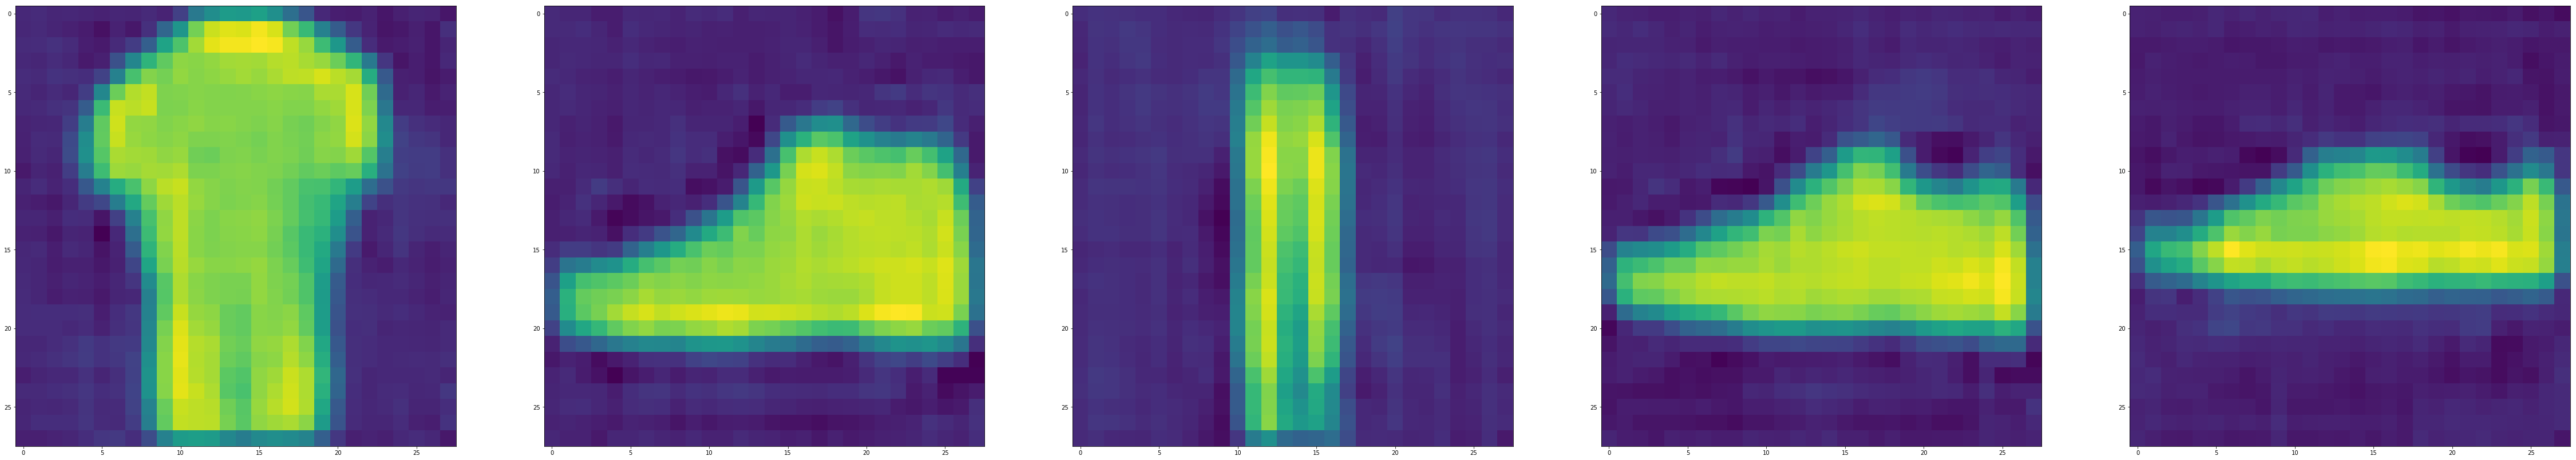

In [18]:
preds = model_2.predict(val_x_n[:10])
f, ax = plt.subplots(1,5)
f.set_size_inches(80, 40)
for i in range(5,10):
    ax[i-5].imshow(preds[i].reshape(28, 28))
plt.show()